# Modeling

## Load Libraries

In [314]:
# Librerias base
import os
import re
import json

# Manipulacion de datos
import pandas as pd
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import collections
from pprint import pprint

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import check_is_fitted
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split

# Datos faltantes
from sklearn.impute import KNNImputer, SimpleImputer

# Metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import fbeta_score, recall_score, precision_score
from sklearn.metrics import mean_squared_error, r2_score

# Modelamiento
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Serializar modelo
import pickle

# Optimización Hiperparametros
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from sklearn.model_selection import KFold

# Configurar pandas
pd.options.display.max_columns = None
pd.options.display.max_rows = 200
#pd.options.display.float_format = '{:,.2f}'.format

## Load Data

In [156]:
# Training set
train = pd.read_parquet('../data/processed/training.gzip')
# Validation set
val = pd.read_parquet('../data/processed/validation.gzip')
# Test set
test = pd.read_parquet('../data/processed/test.gzip')

### Datasets preparation

In [158]:
x_train = train.drop('default', axis=1)
y_train = train.default

x_val = val.drop('default', axis=1)
y_val = val.default

x_test = test.drop('default', axis=1)
y_test = test.default

In [159]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(6780, 9)
(1222, 9)
(1437, 9)


### Custom class for discretizing numercial variables

In [91]:
class NumBinning(BaseEstimator, TransformerMixin):
    def __init__(self, imputer_strategy, knn_imputer):
        # self.X = X
        self.imputer_strategy = imputer_strategy
        self.knn_imputer = knn_imputer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Selet numerical variables
        X = X.select_dtypes(exclude=['object', 'category'])
        num_cols = X.columns.values
        num_index = X.index.values
        
        # Impute missing data
        imputer_strategy = "mean" if self.imputer_strategy > 0.5 else "median"
        if self.knn_imputer > 0.5:
            imputer = KNNImputer(n_neighbors=int(5))
        else:
            imputer = SimpleImputer(strategy=imputer_strategy, missing_values=np.nan)
            
        pipe = Pipeline(steps=[('imputer', imputer)])
        X = pipe.fit_transform(X)
        X = pd.DataFrame(X, columns=num_cols, index=num_index)
        
        X_new = pd.DataFrame(index=X.index.values)
        # Int rate
        X_new['int_rate:(0.0, 0.0823]'] = np.where(X.int_rate <= 0.0823, 1, 0)
        X_new['int_rate:(0.0823, 0.105]'] = np.where((X.int_rate > 0.0823) & (X.int_rate <= 0.105), 1, 0)
        X_new['int_rate:(0.105, 0.127]'] = np.where((X.int_rate > 0.105) & (X.int_rate <= 0.127), 1, 0)
        X_new['int_rate:(0.127, 0.149]'] = np.where((X.int_rate > 0.127) & (X.int_rate <= 0.149), 1, 0)
        X_new['int_rate:(0.149, 0.172]'] = np.where((X.int_rate > 0.149) & (X.int_rate <= 0.172), 1, 0)
        X_new['int_rate:(0.172, 0.194]'] = np.where((X.int_rate > 0.172) & (X.int_rate <= 0.194), 1, 0)
        X_new['int_rate:0.194+'] = np.where(X.int_rate > 0.194, 1, 0)
        # Installments
        X_new['installment:(0, 147.737]'] = np.where(X.installment <= 147.737, 1, 0)
        X_new['installment:(147.737, 279.804]'] = np.where((X.installment > 147.737) & (X.installment <= 279.804), 1, 0)
        X_new['installment:(279.804, 411.871]'] = np.where((X.installment > 279.804) & (X.installment <= 411.871), 1, 0)
        X_new['installment:(411.871, 676.006]'] = np.where((X.installment > 411.871) & (X.installment <= 676.006), 1, 0)
        X_new['installment:(676.006, 808.073]'] = np.where((X.installment > 676.006) & (X.installment <= 808.073), 1, 0)
        X_new['installment:808.073+'] = np.where(X.installment > 808.073, 1, 0)
        # log_annual_inc
        X_new['income:(0, 10.949]'] = np.where(X.log_annual_inc > 10.949, 1, 0)
        X_new['income:(10.949, 12.026]'] = np.where((X.log_annual_inc > 10.949) & (X.log_annual_inc <= 12.026), 1, 0)
        X_new['income:(12.026, 13.103]'] = np.where((X.log_annual_inc > 12.026) & (X.log_annual_inc <= 13.103), 1, 0)
        X_new['income:13.103+'] = np.where(X.log_annual_inc > 13.103, 1, 0)
        # dti
        X_new['dti:(0, 8]'] = np.where(X.dti <= 8, 1, 0)
        X_new['dti:(8, 15]'] = np.where((X.dti > 8) & (X.dti <= 15), 1, 0)
        X_new['dti:(15, 23]'] = np.where((X.dti > 15) & (X.dti <= 23), 1, 0)
        X_new['dti:23+'] = np.where(X.dti > 23, 1, 0)
        # Fico
        X_new['fico:(0, 655]'] = np.where(X.fico <= 655, 1, 0)
        X_new['fico:(655, 698]'] = np.where((X.fico > 655) & (X.fico <= 698), 1, 0)
        X_new['fico:(698, 741]'] = np.where((X.fico > 698) & (X.fico <= 741), 1, 0)
        X_new['fico:(741, 784]'] = np.where((X.fico > 741) & (X.fico <= 784), 1, 0)
        X_new['fico:784+'] = np.where(X.fico > 784, 1, 0)
        # revol_util
        X_new['revol_util:(0, 25]'] = np.where(X.revol_util > 25, 1, 0)
        X_new['revol_util:(25, 50]'] = np.where((X.revol_util > 25) & (X.revol_util <= 50), 1, 0)
        X_new['revol_util:(50, 70]'] = np.where((X.revol_util > 50) & (X.revol_util <= 70), 1, 0)
        X_new['revol_util:(70, 95]'] = np.where((X.revol_util > 70) & (X.revol_util <= 95), 1, 0)
        X_new['revol_util:95+'] = np.where(X.revol_util > 95, 1, 0)
        # inq_last_6mths
        X_new['inquiries:0'] = np.where(X.inq_last_6mths == 0, 1, 0)
        X_new['inquiries:1-2'] = np.where((X.inq_last_6mths > 0) & (X.inq_last_6mths <= 2), 1, 0)
        X_new['inquiries:2+'] = np.where(X.inq_last_6mths > 2, 1, 0)
        # credit_policy
        X_new['cred_pol:0'] = np.where(X.credit_policy == 0, 1, 0)
        X_new['cred_pol:1'] = np.where(X.credit_policy == 1, 1, 0)
        
        # Columnas de referencia
        ref_cols = ['int_rate:(0.105, 0.127]', 'installment:(279.804, 411.871]',
                    'income:(0, 10.949]', 'dti:(8, 15]', 'fico:(698, 741]',
                    'revol_util:(50, 70]', 'cred_pol:0', 'inquiries:0'
                    ]
        
        X_new = X_new.drop(ref_cols, axis=1)
        return X_new

### Custom class for preprocessing categorical variables

In [92]:
def dummy_creation(df, columns_list):
    """Funcion para crear variables dummies
    """
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

In [94]:
class CatDummies(BaseEstimator, TransformerMixin):
    def __init__(self, cat_ref=None) -> None:
        # self.X = X
        self.columns = None
        self.cat_ref = cat_ref
        return None
    
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    
    def transform(self, X):
        # Seleccionar variables categoricas
        X = X.select_dtypes(include=['object', 'category'])
        cat_cols = X.columns.values
        cat_index = X.index.values
        
        # Impute missing values
        pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy="most_frequent", missing_values=np.nan))])
        X = pipe.fit_transform(X)
        X = pd.DataFrame(X, columns=cat_cols, index=cat_index)
        
        # Preparar dataframe
        X = dummy_creation(X, cat_cols)
        if self.cat_ref is not None:
            X = X.reindex(labels=self.cat_ref, axis=1, fill_value=0)
        
        X_new = X.loc[:, ['purpose:small_business', 'purpose:credit_card', 'purpose:major_purchase']].copy()
        X_new.loc[:, 'purpose:education_home_improv'] = sum([X.loc[:, 'purpose:educational'], 
                                                             X.loc[:, 'purpose:home_improvement']])
        X_new.loc[:,'purpose:other_debt_consolidation'] = sum([X.loc[:, 'purpose:all_other'],
                                                               X.loc[:, 'purpose:debt_consolidation']
                                                               ])
        # X_new.loc[:,'purpose:credit_card'] = X.loc[:, 'purpose:credit_card']
        # X_new.loc[:,'purpose:major_purchase'] = X.loc[:, 'purpose:major_purchase']
        
        # Base category column
        ref_cols = ['purpose:education_home_improv']
        
        X_new = X_new.drop(ref_cols, axis=1)
        X_new = X_new * 1
        
        return X_new
    
    def get_feature_names(self):
        return list(self.columns)

## Modeling

### Aux Functions

In [95]:
def live_plot(data_dict, figsize=(7,5), title='', win_size: int = 100):
    """
    Function for plotting in real time bayesian optimization process
    """
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        if len(data) > win_size:
            data = data[-win_size:]
            iterations = np.arange(len(data))[-win_size:] 
        else:
            iterations = np.arange(len(data))
        plt.plot(iterations, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()
    
def adj_live_plot(data_dict, subplot, figsize=(7,5), title='', win_size: int = 100):
    """
    Function for plotting in real time bayesian optimization process
    """
    clear_output(wait=True)
    plt.subplot(*subplot)
    for label,data in data_dict.items():
        if len(data) > win_size:
            data = data[-win_size:]
            iterations = np.arange(len(data))[-win_size:] 
        else:
            iterations = np.arange(len(data))
        plt.plot(iterations, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.legend(loc='center left') # the plot evolves to the right
    
def add_model(data_pipeline, model, smote=False) -> Pipeline:
    """Function for createing whole pipeline for model training
    
        Args
        ----
        data_pipeline: sklearn.pipeline
        model: sklearn model
        smote: boolean, default False
    """
    if smote:
        whole_pipeline = imbPipeline([
            ("data_pipeline", data_pipeline),
            ("model", model)
        ])
    else:
        whole_pipeline = Pipeline([
            ("data_pipeline", data_pipeline),
            ("model", model)
            ])
    return whole_pipeline

### Función para entrenar Regresión Logística

In [181]:
# Data para visualizacion de la optimizacion
roc_auc_data = collections.defaultdict(list)
ks_data = collections.defaultdict(list)
gini_data = collections.defaultdict(list)

cat_col_ref = ['purpose:all_other', 'purpose:credit_card', 
               'purpose:debt_consolidation', 'purpose:educational', 
               'purpose:home_improvement', 'purpose:major_purchase',
               'purpose:small_business']

# Funcion para entrenar y evaluar el modelo con KFold
def train_and_evaluate_rl(
                        # Data
                        scaler_choice,
                        imputer_strategy,
                        knn_imputer,
                        knn_imputer_k,
                        pca_components, 
                        model_penalty,
                        model_C, 
                        model_pos_class_weight,
                        sampling_strategy,
                        lasso_alpha
                        ) -> float:
    """  Funcion para entrenamiento y validacion del modelo

    Args:
        scaler_choice (_type_): _description_
        imputer_strategy (_type_): _description_
        knn_imputer (_type_): _description_
        knn_imputer_k (_type_): _description_
        pca_components (_type_): _description_
        model_penalty (_type_): _description_
        model_C (_type_): _description_
        model_pos_class_weight (_type_): _description_
        lasso_alpha
        
    Returns:
        float: ROC AUC score
        float: KS score
        float: GINI score
    """
    
    #================================
    # Configuracion inicial
    #================================
        
    #======================
    # Configuraciones 
    #======================
    custom_binning = custom_binning_conf
    smote = smote_conf
    custom_categorical = custom_categorical_conf
    
    # Modelo a utilizar
    model_selection = 1
    cv = cv_conf

    # Steps pipeline preprocesor
    feature_eng_step = feature_eng_step_conf
    
    # Mostrar grafico optimizacion
    show_live_plot=show_live_plot_cong
        
    #========
    # Datos
    #========
    X_train = x_data.copy()
    Y_train = y_data.copy()

    # Definicion de columnas numericas y categoricas
    cat_vars = [*X_train.select_dtypes(include='object').columns]
    num_vars = [*X_train.select_dtypes(exclude='object').columns]

    # Estrategia de escalamiento de datos
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    
    # Estrategia de imputacion de datos numericos
    impute_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=impute_strategy)
     
     
    #==========================================
    # Seleccion del modelo
    #==========================================
    print("Modelo seleccionado: Regresión Logistica")
    model =  LogisticRegression(
        penalty="l1" if model_penalty > 0.5 else "l2",
        solver='liblinear',
        C=model_C,
        class_weight={0: 1, 1: model_pos_class_weight}
    )
     
    #==========================================
    # Preprocesamientos
    #==========================================
    if custom_binning:
                
        # Numerical variables transformations
        numeric_transformer = Pipeline(
            steps=[
                ("num_binning", NumBinning(imputer_strategy, knn_imputer))
                ]
        )

        # Categorical variables transformations
        categorical_transformer = Pipeline(
            steps=[
                ('cat_dummy', CatDummies(cat_ref=cat_col_ref))
                ]
        )
        
        # Transformer consolidado
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_vars),
                ("cat", categorical_transformer, cat_vars)
            ],
            remainder='passthrough'
        )
        
        if smote:
            data_pipeline = imbPipeline(steps=[
                                        ("data_processor", preprocessor),
                                        ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                        ('model', model)
                                    ])
        else:
            data_pipeline = Pipeline(steps=[
                                    ("data_processor", preprocessor),
                                    ('model', model)
                                ])
            
    else:
        
        # Categorical variables transformations
        if custom_categorical:
            categorical_transformer = Pipeline(
                steps=[('cat_dummy', CatDummies(cat_ref=cat_col_ref))]
            )
        else:
            categorical_transformer = Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")), 
                    ('ohe', OneHotEncoder(drop='first', handle_unknown="ignore"))
                ]
            )

        # Base transformations
        transformers = []

        if feature_eng_step is None:
            numeric_transformer = Pipeline(
                                    steps=[
                                        ("imputer", imputer)
                                        #("scaler", scaler_cls())
                                    ])
                        
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
                        
            # Numerical variables transformations
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'pca':
            
            numeric_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])   
    
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            # Numerical variables transformations
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])

        elif feature_eng_step == 'lda':
            numeric_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])   
            
            # Numerical variables transformations
            transformers.append(("num", numeric_transformer, num_vars))
            
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'lasso':
            
            numeric_transformer = Pipeline(
                                        steps=[
                                            ("imputer", imputer), 
                                            ("scaler", scaler_cls())
                                        ])    
                        
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
                        
            # Numerical variables transformations
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            # Apply lasso if the model is not a logistic regression
            if model_selection == 1:
                if smote:
                    data_pipeline = imbPipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                                ('model', model)
                                            ])
                else:
                    data_pipeline = Pipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ('model', model)
                                            ])
            else:
                if smote:
                    data_pipeline = imbPipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                                ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                                ('model', model)
                                            ])
                else:
                    data_pipeline = Pipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                                ('model', model)
                                            ])
            
        elif feature_eng_step == 'pca_lda':

            pca_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])
            
            lda_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])
            
            # Numerical variables transformations
            transformers.append(("pca", pca_transformer, num_vars))
            transformers.append(("lda", lda_transformer, num_vars))
            
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'all':
            pca_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])
            
            lda_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])
            
            # Numerical variables transformations
            transformers.append(("pca", pca_transformer, num_vars))
            transformers.append(("lda", lda_transformer, num_vars))
            
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('lasso', SelectFromModel(Lasso(alpha=lasso_alpha))),
                                            ('model', model)
                                        ])

    #===============================
    # Model Pipeline
    #===============================
    #pipeline = add_model(data_pipeline, model, smote)
    kf = KFold(n_splits=cv, random_state=42, shuffle=True)
    
    #=========================
    # Metrics
    #=========================
    # Train
    roc_auc_train = [] 
    ks_train = []
    gini_train = []
    # Validation
    roc_auc_val = []
    ks_val = []
    gini_val = []
    
    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        # print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        data_pipeline.fit(kX_train, ky_train.astype(np.float32))
        
        val_preds = data_pipeline.predict_proba(kX_val)[:, 1]
        val_auc = roc_auc_score(ky_val.astype(np.float32), val_preds)
        val_fpr, val_tpr, _ = roc_curve(ky_val.astype(np.float32), val_preds)
        val_ks = np.max(abs(val_fpr - val_tpr))
        val_gini = 2 * val_auc - 1
        
        train_preds = data_pipeline.predict_proba(kX_train)[:, 1]
        train_auc = roc_auc_score(ky_train.astype(np.float32), train_preds)
        train_fpr, train_tpr, _ = roc_curve(ky_train.astype(np.float32), train_preds)
        train_ks = np.max(abs(train_fpr - train_tpr))
        train_gini = 2 * train_auc - 1
        
        # Add train values
        roc_auc_train.append(train_auc)
        ks_train.append(train_ks)
        gini_train.append(train_gini)
        
        # Add validation values
        roc_auc_val.append(val_auc)
        ks_val.append(val_ks)
        gini_val.append(val_gini)
    
    # Convert to an array
    # Validation
    roc_auc_val = np.array(roc_auc_val)
    ks_val = np.array(ks_val)
    gini_val = np.array(gini_val)
    # Training
    roc_auc_train = np.array(roc_auc_train)
    ks_train = np.array(ks_train)
    gini_train = np.array(gini_train)
    
    # ROC AUC ajusted
    adj_val_roc_auc = (roc_auc_val.mean() -  roc_auc_val.std())
    adj_train_roc_auc = (roc_auc_train.mean() -  roc_auc_train.std())
    obj_roc_auc = adj_val_roc_auc - abs(adj_val_roc_auc - adj_train_roc_auc)
    
    # KS ajusted
    adj_val_ks = (ks_val.mean() - ks_val.std())
    adj_train_ks = (ks_train.mean() - ks_train.std())
    obj_ks = adj_val_ks - abs(adj_val_ks - adj_train_ks)
    
    # Gini ajusted
    adj_val_gini = (gini_val.mean() - gini_val.std())
    adj_train_gini = (gini_train.mean() - gini_train.std())
    obj_gini = adj_val_gini - abs(adj_val_gini - adj_train_gini)
    
    print(f"Validation ROC AUC adjusted score: {adj_val_roc_auc}")
    print(f"Train ROC AUC adjusted score: {adj_train_roc_auc}")
    print("\n")
    print(f"Validation KS adjusted score: {adj_val_ks}")
    print(f"Train KS adjusted score: {adj_train_ks}")
    print("\n")
    print(f"Validation GINI adjusted score: {adj_val_gini}")
    print(f"Train GINI adjusted score: {adj_train_gini}")
    print("\n")

    if show_live_plot:
        # ROC-AUC
        roc_auc_data['train_roc_auc'].append(adj_train_roc_auc)
        roc_auc_data['val_roc_auc'].append(adj_val_roc_auc)
        roc_auc_data['objective'].append(obj_roc_auc)
        # KS
        ks_data['train_ks'].append(adj_train_ks)
        ks_data['val_ks'].append(adj_val_ks)
        ks_data['objective'].append(obj_ks)
        # Gini
        gini_data['train_gini'].append(adj_train_gini)
        gini_data['val_gini'].append(adj_val_gini)
        gini_data['objective'].append(obj_gini)
        # live_plot(roc_auc_data)
        fig, axes = plt.subplots(3, 1, figsize=(12, 8))
        adj_live_plot(roc_auc_data, subplot=(3, 1, 1), win_size=160)
        adj_live_plot(ks_data, subplot=(3, 1, 2), win_size=160)
        adj_live_plot(gini_data, subplot=(3, 1, 3), win_size=160)
        plt.tight_layout()
        plt.show()
    
    return data_pipeline, obj_roc_auc

### Función para entrenar Random Forest

In [182]:
# Data para visualizacion de la optimizacion
roc_auc_data = collections.defaultdict(list)
ks_data = collections.defaultdict(list)
gini_data = collections.defaultdict(list)

cat_col_ref = ['purpose:all_other', 'purpose:credit_card', 
               'purpose:debt_consolidation', 'purpose:educational', 
               'purpose:home_improvement', 'purpose:major_purchase',
               'purpose:small_business']

# Funcion para entrenar y evaluar el modelo con KFold
def train_and_evaluate_rf(
                        # Data
                        scaler_choice,
                        imputer_strategy,
                        knn_imputer,
                        knn_imputer_k,
                        pca_components, 
                        model_penalty,
                        sampling_strategy,
                        lasso_alpha,
                        # Random Forest
                        rf_n_estimators,
                        rf_max_depth,
                        rf_max_features,
                        rf_min_samples_split,
                        rf_criterion,
                        model_pos_class_weight
                        ) -> float:
    """  Funcion para entrenamiento y validacion del modelo

    Args:
        scaler_choice (_type_): _description_
        imputer_strategy (_type_): _description_
        knn_imputer (_type_): _description_
        knn_imputer_k (_type_): _description_
        pca_components (_type_): _description_
        model_penalty (_type_): _description_
        model_C (_type_): _description_
        model_pos_class_weight (_type_): _description_
        model_hidden_layer_size_exp (_type_): _description_
        model_lr_init (_type_): _description_
        model_alpha (_type_): _description_
        model_batch_size (_type_): _description_
        model_max_iter (_type_): _description_
        model_solver (_type_): _description_
        verbose (int, optional): _description_. Defaults to 1.


        model_selection: Indica el modelo a entrenar
                        1 - Regresion logística
                        2 - SVM
                        3 - RED NUERONAL
                        4 - Random Forest
                        5 - XGboost

    Returns:
        float: ROC AUC score
        float: KS score
        float: GINI score
    """
    
    #================================
    # Configuracion inicial
    #================================
        
    #======================
    # Configuraciones 
    #======================
    custom_binning = custom_binning_conf
    smote = smote_conf
    custom_categorical = custom_categorical_conf
    
    # Modelo a utilizar
    model_selection = 2
    cv = cv_conf

    # Steps pipeline preprocesor
    feature_eng_step = feature_eng_step_conf
    
    # Mostrar grafico optimizacion
    show_live_plot=show_live_plot_cong
    
    #========
    # Datos
    #========
    X_train = x_data.copy()
    Y_train = y_data.copy()

    # Numerical and categorical variables
    cat_vars = [*X_train.select_dtypes(include='object').columns]
    num_vars = [*X_train.select_dtypes(exclude='object').columns]

    # Scaling strategy
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    
    # Imputation strategy
    impute_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=impute_strategy)
     
     
    #==========================================
    # Model
    #==========================================
    print("Modelo seleccionado: Random Forest")
    
    if rf_criterion < 0.33:
        criterion = 'gini'
    elif model_penalty < 0.67:
        criterion = 'entropy'
    else:
        criterion = 'log_loss'
    
    rf_n_estimators = int(round(rf_n_estimators, 0))
    model = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=int(rf_max_depth),
                                    max_features=int(rf_max_features),
                                    min_samples_split=int(rf_min_samples_split),
                                    criterion=criterion,
                                    class_weight={0: 1, 1: model_pos_class_weight}
                                    )
     
    #==========================================
    # Preprocessing
    #==========================================
    if custom_binning:
                
        # Numercial variables transformation
        numeric_transformer = Pipeline(
            steps=[
                ("num_binning", NumBinning(imputer_strategy, knn_imputer))
                ]
        )

        # Categorical variables transformation
        categorical_transformer = Pipeline(
            steps=[
                ('cat_dummy', CatDummies(cat_ref=cat_col_ref))
                ]
        )
        
        # Consolidated Transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_vars),
                ("cat", categorical_transformer, cat_vars)
            ],
            remainder='passthrough'
        )
        
        if smote:
            data_pipeline = imbPipeline(steps=[
                                        ("data_processor", preprocessor),
                                        ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                        # ('smote', SMOTE(random_state=42)),
                                        ('model', model)
                                    ])
        else:
            data_pipeline = Pipeline(steps=[
                                    ("data_processor", preprocessor),
                                    ('model', model)
                                ])
            
    else:
        
        # Categorical variables transformation
        if custom_categorical:
            categorical_transformer = Pipeline(
                steps=[('cat_dummy', CatDummies(cat_ref=cat_col_ref))]
            )
        else:
            categorical_transformer = Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")), 
                    ('ohe', OneHotEncoder(drop='first', handle_unknown="ignore"))
                ]
            )

        # Transformaciones base
        transformers = []

        if feature_eng_step is None:
            numeric_transformer = Pipeline(
                                    steps=[
                                        ("imputer", imputer)
                                        #("scaler", scaler_cls())
                                    ])
                        
            # Categorical variables transformation
            transformers.append(("cat", categorical_transformer, cat_vars))
                        
            # Numercial variables transformation
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            # ('smote', SMOTE(random_state=42)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'pca':
            
            numeric_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])   
            
            # Categorical variables transformation
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            # Numercial variables transformation
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            # ('smote', SMOTE(random_state=42)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])

        elif feature_eng_step == 'lda':
            numeric_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])   
            
            # Numercial variables transformation
            transformers.append(("num", numeric_transformer, num_vars))
            
            # Categorical variables transformation
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            # ('smote', SMOTE(random_state=42)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'lasso':
            
            numeric_transformer = Pipeline(
                                        steps=[
                                            ("imputer", imputer), 
                                            ("scaler", scaler_cls())
                                        ])    
                        
            # Categorical variables transformation
            transformers.append(("cat", categorical_transformer, cat_vars))
                        
            # Numercial variables transformation
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            # Apply lasso if the model is not a logistic regression
            if model_selection == 1:
                if smote:
                    data_pipeline = imbPipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                                # ('smote', SMOTE(random_state=42)),
                                                ('model', model)
                                            ])
                else:
                    data_pipeline = Pipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ('model', model)
                                            ])
            else:
                if smote:
                    data_pipeline = imbPipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                                ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                                # ('smote', SMOTE(random_state=42)),
                                                ('model', model)
                                            ])
                else:
                    data_pipeline = Pipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                                ('model', model)
                                            ])
            
        elif feature_eng_step == 'pca_lda':

            pca_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])
            
            lda_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])
            
            # Numercial variables transformation
            transformers.append(("pca", pca_transformer, num_vars))
            transformers.append(("lda", lda_transformer, num_vars))
            
            # Categorical variables transformation
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            # ('smote', SMOTE(random_state=42)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'all':
            pca_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])
            
            lda_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])
            
            # Numercial variables transformation
            transformers.append(("pca", pca_transformer, num_vars))
            transformers.append(("lda", lda_transformer, num_vars))
            
            # Categorical variables transformation
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            # ('smote', SMOTE(random_state=42)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('lasso', SelectFromModel(Lasso(alpha=lasso_alpha))),
                                            ('model', model)
                                        ])

    #===============================
    # Model Pipeline
    #===============================
    #pipeline = add_model(data_pipeline, model, smote)
    kf = KFold(n_splits=cv, random_state=42, shuffle=True)
    
    #=========================
    # Metrics
    #=========================
    # Train
    roc_auc_train = [] 
    ks_train = []
    gini_train = []
    # Validation
    roc_auc_val = []
    ks_val = []
    gini_val = []
    
    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        # print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        data_pipeline.fit(kX_train, ky_train.astype(np.float32))
        
        val_preds = data_pipeline.predict_proba(kX_val)[:, 1]
        val_auc = roc_auc_score(ky_val.astype(np.float32), val_preds)
        val_fpr, val_tpr, _ = roc_curve(ky_val.astype(np.float32), val_preds)
        val_ks = np.max(abs(val_fpr - val_tpr))
        val_gini = 2 * val_auc - 1
        
        train_preds = data_pipeline.predict_proba(kX_train)[:, 1]
        train_auc = roc_auc_score(ky_train.astype(np.float32), train_preds)
        train_fpr, train_tpr, _ = roc_curve(ky_train.astype(np.float32), train_preds)
        train_ks = np.max(abs(train_fpr - train_tpr))
        train_gini = 2 * train_auc - 1
        
        # Add train values
        roc_auc_train.append(train_auc)
        ks_train.append(train_ks)
        gini_train.append(train_gini)
        
        # Add validation values
        roc_auc_val.append(val_auc)
        ks_val.append(val_ks)
        gini_val.append(val_gini)
    
    # Convert to an array
    # Validation
    roc_auc_val = np.array(roc_auc_val)
    ks_val = np.array(ks_val)
    gini_val = np.array(gini_val)
    # Training
    roc_auc_train = np.array(roc_auc_train)
    ks_train = np.array(ks_train)
    gini_train = np.array(gini_train)
    
    # ROC AUC ajusted
    adj_val_roc_auc = (roc_auc_val.mean() -  roc_auc_val.std())
    adj_train_roc_auc = (roc_auc_train.mean() -  roc_auc_train.std())
    obj_roc_auc = adj_val_roc_auc - abs(adj_val_roc_auc - adj_train_roc_auc)
    
    # KS ajusted
    adj_val_ks = (ks_val.mean() - ks_val.std())
    adj_train_ks = (ks_train.mean() - ks_train.std())
    obj_ks = adj_val_ks - abs(adj_val_ks - adj_train_ks)
    
    # Gini ajusted
    adj_val_gini = (gini_val.mean() - gini_val.std())
    adj_train_gini = (gini_train.mean() - gini_train.std())
    obj_gini = adj_val_gini - abs(adj_val_gini - adj_train_gini)
    
    print(f"Validation ROC AUC adjusted score: {adj_val_roc_auc}")
    print(f"Train ROC AUC adjusted score: {adj_train_roc_auc}")
    print("\n")
    print(f"Validation KS adjusted score: {adj_val_ks}")
    print(f"Train KS adjusted score: {adj_train_ks}")
    print("\n")
    print(f"Validation GINI adjusted score: {adj_val_gini}")
    print(f"Train GINI adjusted score: {adj_train_gini}")
    print("\n")

    if show_live_plot:
        # ROC-AUC
        roc_auc_data['train_roc_auc'].append(adj_train_roc_auc)
        roc_auc_data['val_roc_auc'].append(adj_val_roc_auc)
        roc_auc_data['objective'].append(obj_roc_auc)
        # KS
        ks_data['train_ks'].append(adj_train_ks)
        ks_data['val_ks'].append(adj_val_ks)
        ks_data['objective'].append(obj_ks)
        # Gini
        gini_data['train_gini'].append(adj_train_gini)
        gini_data['val_gini'].append(adj_val_gini)
        gini_data['objective'].append(obj_gini)
        # live_plot(roc_auc_data)
        fig, axes = plt.subplots(3, 1, figsize=(12, 8))
        adj_live_plot(roc_auc_data, subplot=(3, 1, 1), win_size=160)
        adj_live_plot(ks_data, subplot=(3, 1, 2), win_size=160)
        adj_live_plot(gini_data, subplot=(3, 1, 3), win_size=160)
        plt.tight_layout()
        plt.show()
    
    return data_pipeline, obj_roc_auc

### Función para entrenar XGBoost

In [183]:
# Data para visualizacion de la optimizacion
roc_auc_data = collections.defaultdict(list)
ks_data = collections.defaultdict(list)
gini_data = collections.defaultdict(list)

cat_col_ref = ['purpose:all_other', 'purpose:credit_card', 
               'purpose:debt_consolidation', 'purpose:educational', 
               'purpose:home_improvement', 'purpose:major_purchase',
               'purpose:small_business']

# Funcion para entrenar y evaluar el modelo con KFold
def train_and_evaluate_xgb(
                        # Data
                        scaler_choice,
                        imputer_strategy,
                        knn_imputer,
                        knn_imputer_k,
                        pca_components, 
                        sampling_strategy,
                        lasso_alpha,
                        # XGBoost
                        xgb_colsample_bytree,
                        xgb_learning_rate,
                        xgb_max_depth,
                        xgb_n_estimators,
                        xgb_gamma,
                        xgb_reg_lambda,
                        xgb_reg_alpha,
                        xgb_subsample,
                        xgb_scale_pos_weight
                        ) -> float:
    """  Funcion para entrenamiento y validacion del modelo

    Args:
        scaler_choice (_type_): _description_
        imputer_strategy (_type_): _description_
        knn_imputer (_type_): _description_
        knn_imputer_k (_type_): _description_
        pca_components (_type_): _description_
        sampling_strategy (_type_): _description_
        lasso_alpha (_type_): _description_

    Returns:
        float: ROC AUC score
        float: KS score
        float: GINI score
    """
    
    #================================
    # Configuracion inicial
    #================================
        
    #======================
    # Configuraciones 
    #======================
    custom_binning = custom_binning_conf
    smote = smote_conf
    custom_categorical = custom_categorical_conf
    
    # Modelo a utilizar
    model_selection = 3
    cv = cv_conf

    # Steps pipeline preprocesor
    feature_eng_step = feature_eng_step_conf
    
    # Mostrar grafico optimizacion
    show_live_plot=show_live_plot_cong
    
    #========
    # Datos
    #========
    X_train = x_data.copy()
    Y_train = y_data.copy()

    # Numerical and categorical variables
    cat_vars = [*X_train.select_dtypes(include='object').columns]
    num_vars = [*X_train.select_dtypes(exclude='object').columns]

    # Scaling strategy
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    
    # Imputation strategy
    impute_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=impute_strategy)
     
     
    #==========================================
    # Model
    #==========================================
    print("Modelo seleccionado: XGBoost")
    model = xgb.XGBClassifier(objective ='reg:linear',
                                colsample_bytree=xgb_colsample_bytree,
                                learning_rate=xgb_learning_rate,
                                max_depth=int(xgb_max_depth), 
                                n_estimators=int(xgb_n_estimators),
                                gamma=xgb_gamma,
                                reg_lambda=xgb_reg_lambda,
                                reg_alpha=xgb_reg_alpha,
                                subsample=xgb_subsample,
                                scale_pos_weight=xgb_scale_pos_weight
                                )
     
    #==========================================
    # Preprocessing
    #==========================================
    if custom_binning:
                
        # Numerical variable transformation
        numeric_transformer = Pipeline(
            steps=[
                # ("imputer", imputer), 
                ("num_binning", NumBinning(imputer_strategy, knn_imputer))
                ]
        )

        # Categorical variables transformations
        categorical_transformer = Pipeline(
            steps=[
                # ("imputer", SimpleImputer(strategy="most_frequent")), 
                ('cat_dummy', CatDummies(cat_ref=cat_col_ref))
                ]
        )
        
        # Consolidated Transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_vars),
                ("cat", categorical_transformer, cat_vars)
            ],
            remainder='passthrough'
        )
        
        if smote:
            data_pipeline = imbPipeline(steps=[
                                        ("data_processor", preprocessor),
                                        ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                        ('model', model)
                                    ])
        else:
            data_pipeline = Pipeline(steps=[
                                    ("data_processor", preprocessor),
                                    ('model', model)
                                ])
            
    else:
        
        # Categorical variables transformations
        if custom_categorical:
            categorical_transformer = Pipeline(
                steps=[('cat_dummy', CatDummies(cat_ref=cat_col_ref))]
            )
        else:
            categorical_transformer = Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")), 
                    ('ohe', OneHotEncoder(drop='first', handle_unknown="ignore"))
                ]
            )

        # Transformaciones base
        transformers = []

        if feature_eng_step is None:
            numeric_transformer = Pipeline(
                                        steps=[
                                            ("imputer", imputer)
                                        ])
                        
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
                        
            # Numerical variable transformation
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'pca':
            
            numeric_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])   
            
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            # Numerical variable transformation
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])

        elif feature_eng_step == 'lda':
            numeric_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])   
            
            # Numerical variable transformation
            transformers.append(("num", numeric_transformer, num_vars))
            
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'lasso':
            
            numeric_transformer = Pipeline(
                                        steps=[
                                            ("imputer", imputer), 
                                            ("scaler", scaler_cls())
                                        ])    
                        
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
                        
            # Numerical variable transformation
            transformers.append(("num", numeric_transformer, num_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            # Apply lasso if the model is not a logistic regression
            if model_selection == 1:
                if smote:
                    data_pipeline = imbPipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                                ('model', model)
                                            ])
                else:
                    data_pipeline = Pipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ('model', model)
                                            ])
            else:
                if smote:
                    data_pipeline = imbPipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                                ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                                ('model', model)
                                            ])
                else:
                    data_pipeline = Pipeline(steps=[
                                                ("data_processor", preprocessor),
                                                ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                                ('model', model)
                                            ])
            
        elif feature_eng_step == 'pca_lda':

            pca_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])
            
            lda_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])
            
            # Numerical variable transformation
            transformers.append(("pca", pca_transformer, num_vars))
            transformers.append(("lda", lda_transformer, num_vars))
            
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('model', model)
                                        ])
            
        elif feature_eng_step == 'all':
            pca_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("pca", PCA(n_components=int(pca_components)))
                        ])
            
            lda_transformer = Pipeline(
                        steps=[
                            ("imputer", imputer), 
                            ("scaler", scaler_cls()),
                            ("lda", LDA(n_components=1))
                        ])
            
            # Numerical variable transformation
            transformers.append(("pca", pca_transformer, num_vars))
            transformers.append(("lda", lda_transformer, num_vars))
            
            # Categorical variables transformations
            transformers.append(("cat", categorical_transformer, cat_vars))
            
            preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'
            )
            
            if smote:
                data_pipeline = imbPipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ("lasso", SelectFromModel(Lasso(alpha=lasso_alpha))),
                                            ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
                                            ('model', model)
                                        ])
            else:
                data_pipeline = Pipeline(steps=[
                                            ("data_processor", preprocessor),
                                            ('lasso', SelectFromModel(Lasso(alpha=lasso_alpha))),
                                            ('model', model)
                                        ])

    #===============================
    # Model Pipeline
    #===============================
    #pipeline = add_model(data_pipeline, model, smote)
    kf = KFold(n_splits=cv, random_state=42, shuffle=True)
    
    #=========================
    # Metrics
    #=========================
    # Train
    roc_auc_train = [] 
    ks_train = []
    gini_train = []
    # Validation
    roc_auc_val = []
    ks_val = []
    gini_val = []
    
    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        # print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        data_pipeline.fit(kX_train, ky_train.astype(np.float32))
        
        val_preds = data_pipeline.predict_proba(kX_val)[:, 1]
        val_auc = roc_auc_score(ky_val.astype(np.float32), val_preds)
        val_fpr, val_tpr, _ = roc_curve(ky_val.astype(np.float32), val_preds)
        val_ks = np.max(abs(val_fpr - val_tpr))
        val_gini = 2 * val_auc - 1
        
        train_preds = data_pipeline.predict_proba(kX_train)[:, 1]
        train_auc = roc_auc_score(ky_train.astype(np.float32), train_preds)
        train_fpr, train_tpr, _ = roc_curve(ky_train.astype(np.float32), train_preds)
        train_ks = np.max(abs(train_fpr - train_tpr))
        train_gini = 2 * train_auc - 1
        
        # Train values
        roc_auc_train.append(train_auc)
        ks_train.append(train_ks)
        gini_train.append(train_gini)
        
        # Validation values
        roc_auc_val.append(val_auc)
        ks_val.append(val_ks)
        gini_val.append(val_gini)
    
    # Convert to an array
    # Validation
    roc_auc_val = np.array(roc_auc_val)
    ks_val = np.array(ks_val)
    gini_val = np.array(gini_val)
    # Training
    roc_auc_train = np.array(roc_auc_train)
    ks_train = np.array(ks_train)
    gini_train = np.array(gini_train)
    
    # ROC AUC ajusted
    adj_val_roc_auc = (roc_auc_val.mean() -  roc_auc_val.std())
    adj_train_roc_auc = (roc_auc_train.mean() -  roc_auc_train.std())
    obj_roc_auc = adj_val_roc_auc - abs(adj_val_roc_auc - adj_train_roc_auc)
    
    # KS ajusted
    adj_val_ks = (ks_val.mean() - ks_val.std())
    adj_train_ks = (ks_train.mean() - ks_train.std())
    obj_ks = adj_val_ks - abs(adj_val_ks - adj_train_ks)
    
    # Gini ajusted
    adj_val_gini = (gini_val.mean() - gini_val.std())
    adj_train_gini = (gini_train.mean() - gini_train.std())
    obj_gini = adj_val_gini - abs(adj_val_gini - adj_train_gini)
    
    print(f"Validation ROC AUC adjusted score: {adj_val_roc_auc}")
    print(f"Train ROC AUC adjusted score: {adj_train_roc_auc}")
    print("\n")
    print(f"Validation KS adjusted score: {adj_val_ks}")
    print(f"Train KS adjusted score: {adj_train_ks}")
    print("\n")
    print(f"Validation GINI adjusted score: {adj_val_gini}")
    print(f"Train GINI adjusted score: {adj_train_gini}")
    print("\n")

    if show_live_plot:
        # ROC-AUC
        roc_auc_data['train_roc_auc'].append(adj_train_roc_auc)
        roc_auc_data['val_roc_auc'].append(adj_val_roc_auc)
        roc_auc_data['objective'].append(obj_roc_auc)
        # KS
        ks_data['train_ks'].append(adj_train_ks)
        ks_data['val_ks'].append(adj_val_ks)
        ks_data['objective'].append(obj_ks)
        # Gini
        gini_data['train_gini'].append(adj_train_gini)
        gini_data['val_gini'].append(adj_val_gini)
        gini_data['objective'].append(obj_gini)
        # live_plot(roc_auc_data)
        fig, axes = plt.subplots(3, 1, figsize=(12, 8))
        adj_live_plot(roc_auc_data, subplot=(3, 1, 1), win_size=160)
        adj_live_plot(ks_data, subplot=(3, 1, 2), win_size=160)
        adj_live_plot(gini_data, subplot=(3, 1, 3), win_size=160)
        plt.tight_layout()
        plt.show()
    
    return data_pipeline, obj_roc_auc

## Configuracion para entrenar modelo

In [299]:
"""
---------------
INSTRUCTIONS
---------------

--------------------------
1. Select model
--------------------------
model_selection_conf :  1 - Regresion logística
                        2 - Random Forest
                        3 - XGboost

# Croos validation
cv_conf : k value for cross validation

--------------------------
2. Preprocesamientos
--------------------------                        
feature_eng_step_conf:  - None (no preprocessing)
                        - pca (pca to numerical variables)
                        - lda (lda to numerical variables)
                        - lasso (lasso to numerical variables)
                        - pca_lda (pca and lda to numerical variables)
                        - all (all transformations)
                        
custom_binning_conf:    - True (apply woe transformations to numerical and
                                categorical variables)
                        - False
                        
custom_categorical_conf:    - True (apply woe transformation to categorical
                                    variables, it can be used when custom_binning_conf = False)
                            - False
                        
smote_conf: - True (apply data balancing with smote)
            - False

"""

# Data for visualizing optimization process
roc_auc_data = collections.defaultdict(list)
ks_data = collections.defaultdict(list)
gini_data = collections.defaultdict(list)

# Data
x_data, y_data = x_train, y_train

# Model
model_selection_conf = 1

# k Cross validation
cv_conf = 10

# Woe Transformations
custom_binning_conf = False

# Select preprocessing
feature_eng_step_conf = 'lda'
custom_categorical_conf = False

# Smote
smote_conf = False

# Show optimization plot
show_live_plot_cong = True

pca_components = (x_train
                  .select_dtypes(exclude=['object', 'category'])
                  .shape[1])

#=================================
# Optimization params
#=================================
if model_selection_conf == 1:
    print("Hyperparamers for RL")
    pbounds = dict(
        # Data
        scaler_choice=(0, 1),
        imputer_strategy=(0, 1),
        knn_imputer=(0,1),
        knn_imputer_k=(3, 7),
        pca_components=(2, pca_components),
        sampling_strategy=(0.3, 0.5), # SMOTE
        lasso_alpha=(0.00001, 0.001),
        # Model
        model_penalty=(0, 1), # Ridge - Lasso 
        model_C=(0.00001, 1), # alpha
        model_pos_class_weight=(1, 100)
    )
elif model_selection_conf == 2:
    print("Hyperparamers for RF")
    pbounds = dict(
        # Data
        scaler_choice=(0, 1),
        imputer_strategy=(0, 1),
        knn_imputer=(0,1),
        knn_imputer_k=(3, 7),
        pca_components=(2, pca_components),
        sampling_strategy=(0.3, 0.5), # SMOTE
        lasso_alpha=(0.00001, 0.001),
        # Hiperparametros random forest
        model_penalty=(0, 1),
        rf_n_estimators=(100, 500),
        rf_max_depth=(2, 20),
        rf_max_features=(8, 60),
        rf_min_samples_split=(2, 10),
        rf_criterion=(0, 1),
        model_pos_class_weight=(1, 100)
    )
else:
    print("Hyperparamers for XGB")
    pbounds = dict(
        # Data
        scaler_choice=(0, 1),
        imputer_strategy=(0, 1),
        knn_imputer=(0,1),
        knn_imputer_k=(3, 7),
        pca_components=(2, pca_components),
        sampling_strategy=(0.3, 0.5), # SMOTE
        lasso_alpha=(0.00001, 0.001),
        # Hiperparametros xgboost
        xgb_colsample_bytree=(0.1, 1),
        xgb_learning_rate=(0.0001, 1),
        xgb_n_estimators=(100, 500),
        xgb_gamma=(0, 10),
        xgb_reg_lambda=(0, 10),
        xgb_reg_alpha=(0, 10),
        xgb_max_depth=(2, 20),
        xgb_subsample=(0.5, 1),
        xgb_scale_pos_weight=(20, 40)
    )
    
# Black box funtion
if model_selection_conf == 1:
    print("Target function: RL")
    def target_func(**kwargs):
        """ Black box function for bayes optimization
        """
        model, result = train_and_evaluate_rl(**kwargs)
        return result
    
elif model_selection_conf == 2:
    print("Target function: RF")
    def target_func(**kwargs):
        """ Black box function for bayes optimization
        """
        model, result = train_and_evaluate_rf(**kwargs)
        return result
    
else:
    print("Target function: XGB")
    def target_func(**kwargs):
        """ Black box function for bayes optimization
        """
        model, result = train_and_evaluate_xgb(**kwargs)
        return result
    
# Bayesian Optimization
optimizer = BayesianOptimization(
    f=target_func,
    pbounds=pbounds,
    verbose=2,
    random_state=42
)

Hyperparamers for RL
Target function: RL


### Hyperparameter optimization

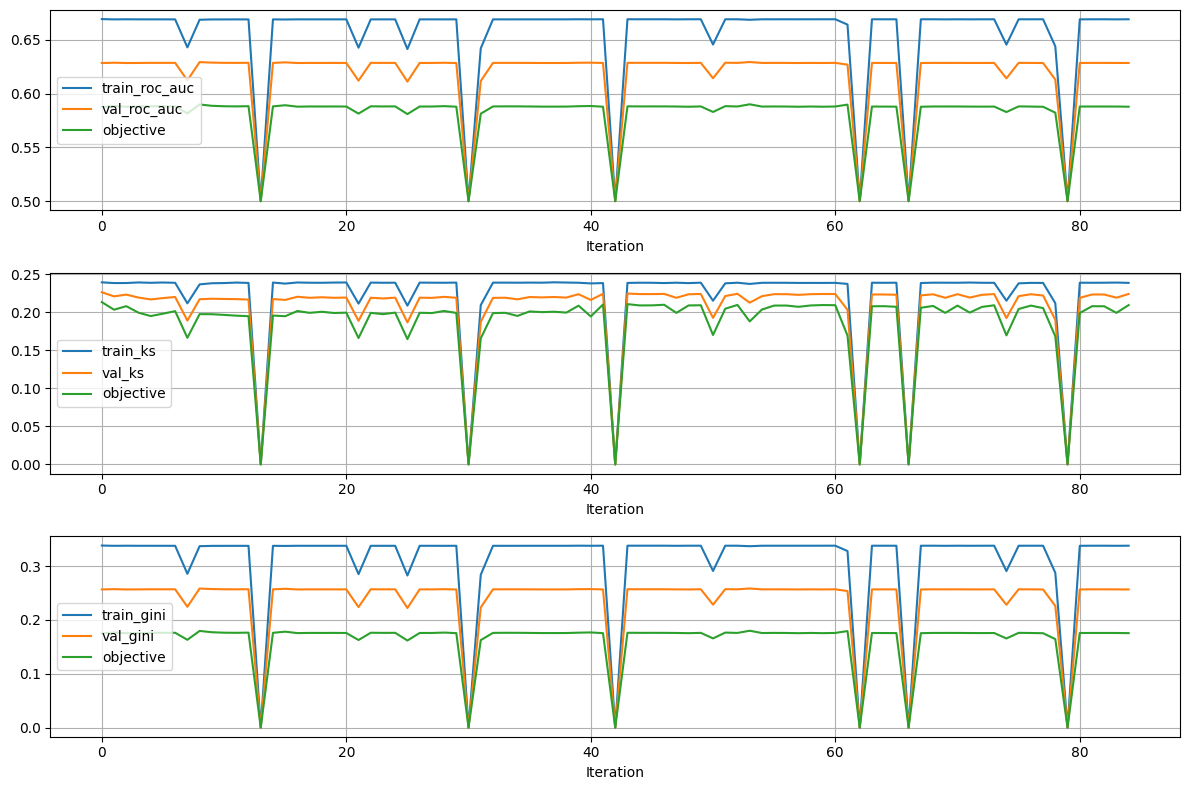

In [300]:
models = {1: 'RL', 2:'RF', 3:'XGB'}

# Optimization process logs
model_id = 2
model = models[model_id]
model_seq = 12 #  RL -> 4 , RL -> 5, XGB -> 7, XGB ->  8, XGB ->10, RF -> 11
path = '../data/models/train/hyperparams'
logger = JSONLogger(path=f'{path}/MOD{model_seq}_{model}.json')
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# Optimization
optimizer.maximize(
    n_iter=80
)

### Best Hyperparamers

In [301]:
optimizer.max["params"]

{'imputer_strategy': 0.012822663913136134,
 'knn_imputer': 0.6228659780543814,
 'knn_imputer_k': 4.218265533763853,
 'lasso_alpha': 0.00031970902581341813,
 'model_C': 0.044483652096020745,
 'model_penalty': 0.8167872374915031,
 'model_pos_class_weight': 22.09815829974078,
 'pca_components': 6.664601635957697,
 'sampling_strategy': 0.3876542667030801,
 'scaler_choice': 0.44634280090867573}

### Create model using best Hyperparamers

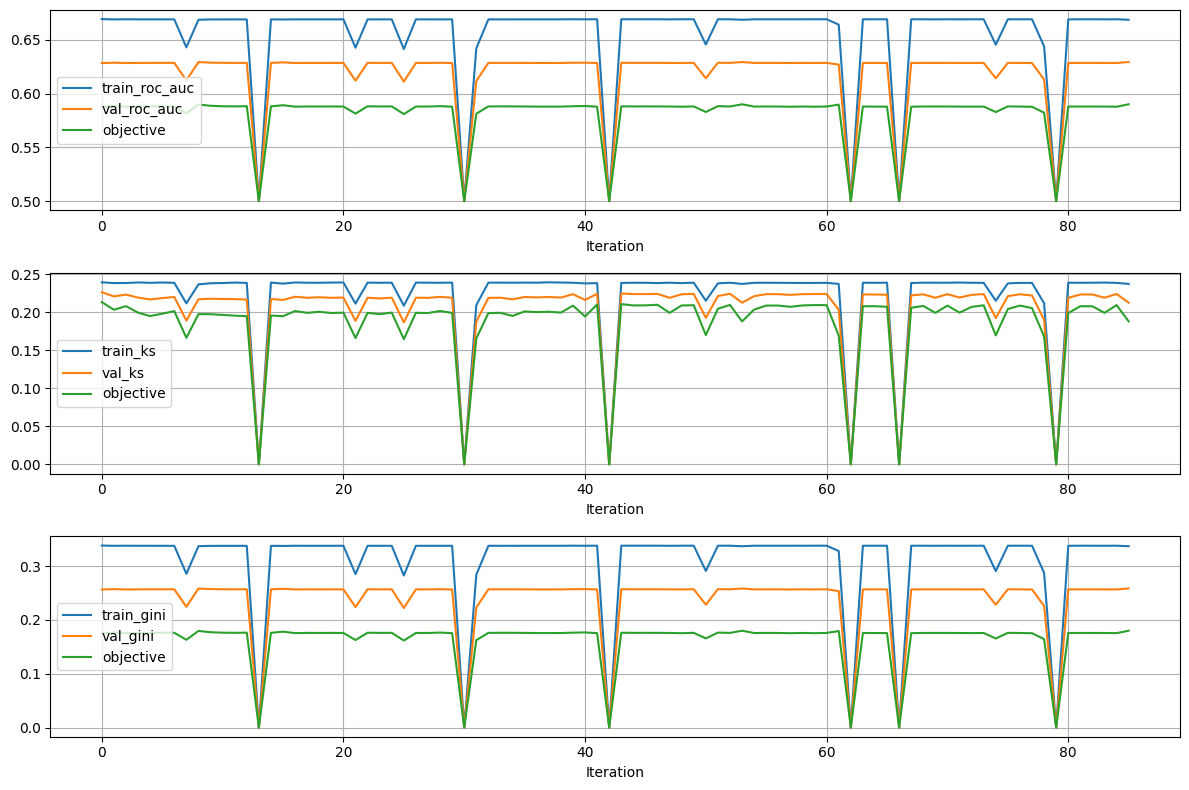

In [302]:
# Best model
if model_selection_conf == 1:
    print("Target function: RL")
    best_model, best_result = train_and_evaluate_rl(**optimizer.max["params"])
    
elif model_selection_conf == 2:
    print("Target function: RF")
    best_model, best_result = train_and_evaluate_rf(**optimizer.max["params"])
    
else:
    print("Target function: XGB")
    best_model, best_result = train_and_evaluate_xgb(**optimizer.max["params"])


In [303]:
best_model

Pipeline(steps=[('data_processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=4)),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('lda',
                                                                   LinearDiscriminantAnalysis(n_components=1))]),
                                                  ['credit_policy', 'int_rate',
                                                   'installment', 'dti', 'fico',
                                                   'revol_util',
                                                   'inq_last_6mths',
                                                   'log_annual_inc']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['purpose'])])),
                ('model',
                 LogisticRegression(C=0.044483652096020745,
                                    class_weight={0: 1, 1: 22.09815829974078},
                                    penalty='l1', solver='liblinear'))])

In [304]:
best_result

0.5899848225191138

## Test best model using all datasets

In [305]:
# Function for testing the best model
def test_best_model(x_data=None, y_data=None, dataset_name='test',
                    filename=None, print_pred_file=False, 
                    print_metrics_file=False, roc_data=False,
                    file_path=None):

    """ Funcion para probar el modelo con el set de datos completos, 
        el set de validación y el set de prueba

    Args:
        dataset_name (str, optional):
                                1. train
                                2. test
                                3. validation
                                4. total
    """

    if dataset_name == 'train':
        df_x, df_y = x_data, y_data
        val_preds = best_model.predict_proba(df_x)[:, 1]
        
        # Metrics
        roc_auc = roc_auc_score(df_y.astype(np.int32), val_preds)
        fpr, tpr, threshold = roc_curve(df_y.astype(np.float32), val_preds,
                                        drop_intermediate=False)
        precision, recall, thresholds = precision_recall_curve(df_y.astype(np.float32),
                                                               val_preds)
        ks = np.max(abs(fpr - tpr))
        gini = 2 * roc_auc - 1
        metricas = pd.DataFrame({'ROC AUC': [roc_auc],
                                 'KS': [ks],
                                 'GINI': [gini]
                                 })
        
        roc_df = pd.DataFrame({'fpr': fpr,
                               'tpr': tpr,
                               'threshold': threshold
                               })
        
        prec_recall_df = pd.DataFrame({'precision': precision,
                                       'recall': recall
                                       })
        thresholds = pd.DataFrame({'threshold': thresholds})
        prec_recall_df = prec_recall_df.merge(thresholds, left_index=True, right_index=True)
        
        if roc_data:
            if filename is not None:
                if file_path is not None:
                    roc_df.to_csv(rf"{file_path}/roc/ROC_MOD_{filename}.csv", index=False)
                    prec_recall_df.to_csv(rf"{file_path}/roc/PREC_REC_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    roc_df.to_csv(rf"../data/models/train/roc/ROC_MOD_{filename}.csv", index=False)
                    prec_recall_df.to_csv(rf"../data/models/train/roc/PREC_REC_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        if print_metrics_file:
            if filename is not None:
                if file_path is not None:
                    metricas.to_csv(rf"{file_path}/metrics/MTR_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    metricas.to_csv(rf"../data/models/train/metrics/MTR_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        # Predicitons
        if print_pred_file:
            if filename is not None:
                filename = f"{filename}"
                file = pd.DataFrame(data=dict(id=df_x.index, 
                                              predicted_bad=val_preds,
                                              actual_bad=df_y)
                                    )
                if file_path is not None:
                    file.to_csv(rf"{file_path}/predictions/MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    file.to_csv(rf"../data/models/train/predictions/MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        return f"Train set ROC_AUC score: {roc_auc} - KS score: {ks} - GINI score: {gini}"
    
    if dataset_name == 'test':
        df_x, df_y = x_data, y_data
        val_preds = best_model.predict_proba(df_x)[:, 1]
        
        # Metrics
        roc_auc = roc_auc_score(df_y.astype(np.int32), val_preds)
        fpr, tpr, threshold = roc_curve(df_y.astype(np.float32), val_preds,
                                        drop_intermediate=False)
        precision, recall, thresholds = precision_recall_curve(df_y.astype(np.float32),
                                                               val_preds)
        ks = np.max(abs(fpr - tpr))
        gini = 2 * roc_auc - 1
        metricas = pd.DataFrame({'ROC AUC': [roc_auc],
                                 'KS': [ks],
                                 'GINI': [gini]
                                 })
        
        roc_df = pd.DataFrame({'fpr': fpr,
                               'tpr': tpr,
                               'threshold': threshold
                               })
        
        prec_recall_df = pd.DataFrame({'precision': precision,
                                       'recall': recall
                                       })
        thresholds = pd.DataFrame({'threshold': thresholds})
        prec_recall_df = prec_recall_df.merge(thresholds, left_index=True, right_index=True)
        
        if roc_data:
            if filename is not None:
                if file_path is not None:
                    roc_df.to_csv(rf"{file_path}/roc/ROC_MOD_{filename}.csv", index=False)
                    prec_recall_df.to_csv(rf"{file_path}/roc/PREC_REC_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    roc_df.to_csv(rf"../data/models/test/roc/ROC_MOD_{filename}.csv", index=False)
                    prec_recall_df.to_csv(rf"../data/models/test/roc/PREC_REC_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        if print_metrics_file:
            if filename is not None:
                if file_path is not None:
                    metricas.to_csv(rf"{file_path}/metrics/MTR_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    metricas.to_csv(rf"../data/models/test/metrics/MTR_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        # Predicitons
        if print_pred_file:
            if filename is not None:
                filename = f"{filename}"
                file = pd.DataFrame(data=dict(id=df_x.index, 
                                              predicted_bad=val_preds,
                                              actual_bad=df_y)
                                    )
                if file_path is not None:
                    file.to_csv(rf"{file_path}/predictions/MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    file.to_csv(rf"../data/models/test/predictions/MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        return f"Test set ROC_AUC score: {roc_auc} - KS score: {ks} - GINI score: {gini}"
    
    if dataset_name == 'validation':
        df_x, df_y = x_data, y_data
        val_preds = best_model.predict_proba(df_x)[:, 1]
        
        # Metrics
        roc_auc = roc_auc_score(df_y.astype(np.int32), val_preds)
        fpr, tpr, threshold = roc_curve(df_y.astype(np.float32), val_preds,
                                        drop_intermediate=False)
        precision, recall, thresholds = precision_recall_curve(df_y.astype(np.float32),
                                                               val_preds)
        ks = np.max(abs(fpr - tpr))
        gini = 2 * roc_auc - 1
        metricas = pd.DataFrame({'ROC AUC': [roc_auc],
                                 'KS': [ks],
                                 'GINI': [gini]
                                 })
        
        roc_df = pd.DataFrame({'fpr': fpr,
                               'tpr': tpr,
                               'threshold': threshold
                               })
        
        prec_recall_df = pd.DataFrame({'precision': precision,
                                       'recall': recall
                                       })
        thresholds = pd.DataFrame({'threshold': thresholds})
        prec_recall_df = prec_recall_df.merge(thresholds, left_index=True, right_index=True)
        
        if roc_data:
            if filename is not None:
                if file_path is not None:
                    roc_df.to_csv(rf"{file_path}/roc/ROC_MOD_{filename}.csv", index=False)
                    prec_recall_df.to_csv(rf"{file_path}/roc/PREC_REC_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    roc_df.to_csv(rf"../data/models/validation/roc/ROC_MOD_{filename}.csv", index=False)
                    prec_recall_df.to_csv(rf"../data/models/validation/roc/PREC_REC_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        if print_metrics_file:
            if filename is not None:
                if file_path is not None:
                    metricas.to_csv(rf"{file_path}/metrics/MTR_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    metricas.to_csv(rf"../data/models/validation/metrics/MTR_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        # Predicitons
        if print_pred_file:
            if filename is not None:
                filename = f"{filename}"
                file = pd.DataFrame(data=dict(id=df_x.index, 
                                              predicted_bad=val_preds,
                                              actual_bad=df_y)
                                    )
                if file_path is not None:
                    file.to_csv(rf"{file_path}/predictions/MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    file.to_csv(rf"../data/models/validation/predictions/MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        return f"Validation set ROC_AUC score: {roc_auc} - KS score: {ks} - GINI score: {gini}"
        
    elif dataset_name == 'total':
        df_x, df_y = x_data, y_data
        val_preds = best_model.predict_proba(df_x)[:, 1]
        
        # Metrics
        roc_auc = roc_auc_score(df_y.astype(np.int32), val_preds)
        fpr, tpr, threshold = roc_curve(df_y.astype(np.float32), val_preds,
                                        drop_intermediate=False)
        precision, recall, thresholds = precision_recall_curve(df_y.astype(np.float32),
                                                               val_preds)
        ks = np.max(abs(fpr - tpr))
        gini = 2 * roc_auc - 1
        metricas = pd.DataFrame({'ROC AUC': [roc_auc],
                                 'KS': [ks],
                                 'GINI': [gini]
                                 })
        
        roc_df = pd.DataFrame({'fpr': fpr,
                               'tpr': tpr,
                               'threshold': threshold
                               })
        
        prec_recall_df = pd.DataFrame({'precision': precision,
                                       'recall': recall
                                       })
        thresholds = pd.DataFrame({'threshold': thresholds})
        prec_recall_df = prec_recall_df.merge(thresholds, left_index=True, right_index=True)
        
        if roc_data:
            if filename is not None:
                if file_path is not None:
                    roc_df.to_csv(rf"{file_path}/roc/ROC_MOD_{filename}.csv", index=False)
                    prec_recall_df.to_csv(rf"{file_path}/roc/PREC_REC_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    roc_df.to_csv(rf"../data/models/full/roc/ROC_MOD_{filename}.csv", index=False)
                    prec_recall_df.to_csv(rf"../data/models/full/roc/PREC_REC_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        if print_metrics_file:
            if filename is not None:
                if file_path is not None:
                    metricas.to_csv(rf"{file_path}/metrics/MTR_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    metricas.to_csv(rf"../data/models/full/metrics/MTR_MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        # Predicitons
        if print_pred_file:
            if filename is not None:
                filename = f"{filename}"
                file = pd.DataFrame(data=dict(id=df_x.index, 
                                              predicted_bad=val_preds,
                                              actual_bad=df_y)
                                    )
                if file_path is not None:
                    file.to_csv(rf"{file_path}/predictions/MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
                else:
                    file.to_csv(rf"../data/models/full/predictions/MOD_{filename}.csv", index=False)
                    print(f"File {filename} generated")
        
        return f"Full set ROC_AUC score: {roc_auc} - KS score: {ks} - GINI score: {gini}"

In [306]:
# Test best model using training data
file_path = '../data/models/train'
filename = f'{model_seq}_{model}'
x_data = x_train.copy()
y_data = y_train.copy()
test_best_model(x_data=x_data, y_data=y_data, 
                dataset_name='train', filename=filename,
                print_metrics_file=True, print_pred_file=True,
                roc_data=True, file_path=file_path)

File 12_RF generated
File 12_RF generated
File 12_RF generated


'Train set ROC_AUC score: 0.6712254630143063 - KS score: 0.24128990918388726 - GINI score: 0.3424509260286126'

In [307]:
# Test best model using validation data
file_path = '../data/models/validation'
filename = f'{model_seq}_{model}'
x_data = x_val.copy()
y_data = y_val.copy()
test_best_model(x_data=x_data, y_data=y_data, 
                dataset_name='validation', filename=filename,
                print_metrics_file=True, print_pred_file=True,
                roc_data=True, file_path=file_path)

File 12_RF generated
File 12_RF generated
File 12_RF generated


'Validation set ROC_AUC score: 0.7006603811115089 - KS score: 0.3255261168795004 - GINI score: 0.4013207622230177'

In [308]:
# Test best model using test data
file_path = '../data/models/test'
filename = f'{model_seq}_{model}'
x_data = x_test.copy()
y_data = y_test.copy()
test_best_model(x_data=x_data, y_data=y_data, 
                dataset_name='test', filename=filename,
                print_metrics_file=True, print_pred_file=True,
                roc_data=True, file_path=file_path)

File 12_RF generated
File 12_RF generated
File 12_RF generated


'Test set ROC_AUC score: 0.687604913367674 - KS score: 0.2625013508158929 - GINI score: 0.3752098267353481'

In [309]:
# Test best model using all data
x_full = pd.concat([x_train, x_val, x_test], axis=0)
y_full = pd.concat([y_train, y_val, y_test], axis=0)

file_path = '../data/models/full'
filename = f'{model_seq}_{model}'
test_best_model(x_data=x_full, y_data=y_full, 
                dataset_name='total', filename=filename,
                print_metrics_file=True, print_pred_file=True,
                roc_data=True, file_path=file_path)

File 12_RF generated
File 12_RF generated
File 12_RF generated


'Full set ROC_AUC score: 0.6777012519674329 - KS score: 0.2446919395925966 - GINI score: 0.35540250393486583'

## Serialize selected model


In the model_evaluation notebook logistic regresion, ramdon forest and xgboost models were evaluated.

For this case the logistic regresion was the selected model.

In [310]:
def save_model(filename, object):
    with open(f"{filename}", 'wb') as file:
        pickle.dump(object, file)
        
def load_model(filename):
    with open(f'{filename}', 'rb') as file:
        model = pickle.load(file)
    return model

## Load selected model hyperparams

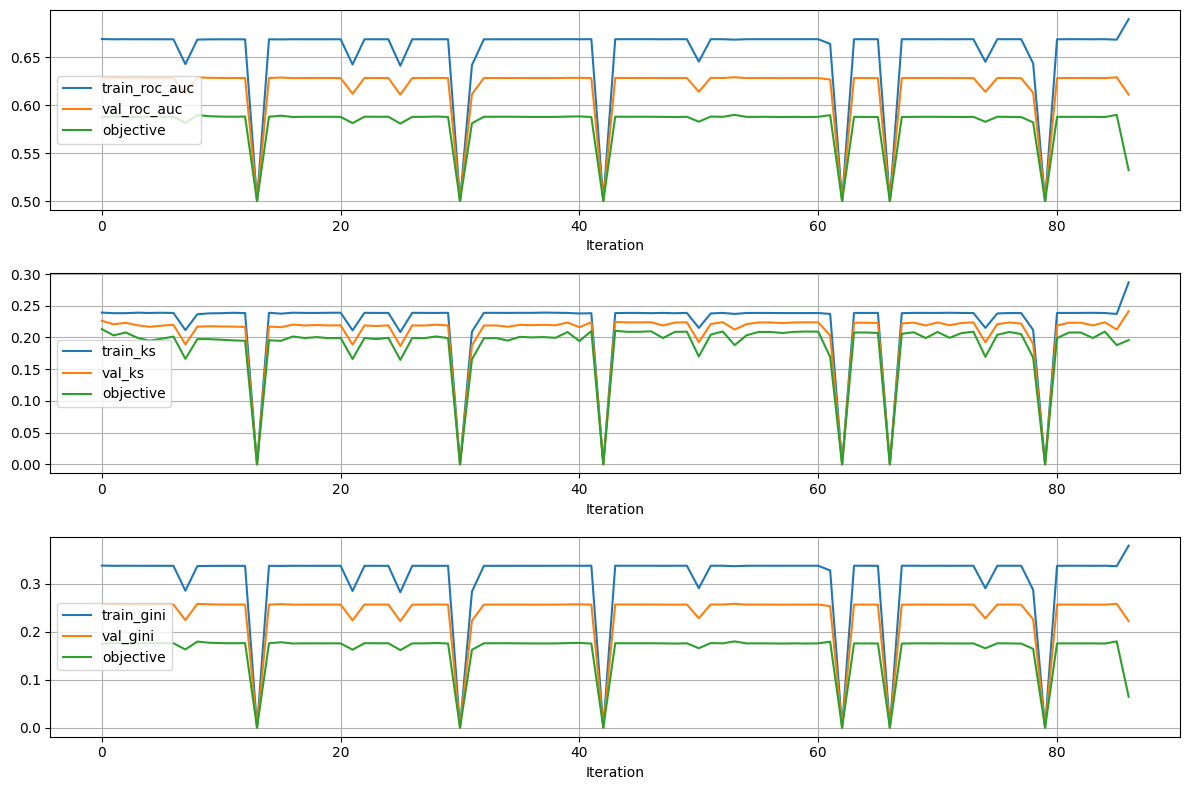

In [355]:
JSON = f'../data/models/train/hyperparams/MOD4_RL.json'
with open(JSON, 'r') as archivo:
    datos_json = [json.loads(line) for line in archivo]
    
params_df = pd.DataFrame(datos_json)
best_params = params_df.loc[params_df.target == params_df.target.max(), 'params'][47]

best_model, best_result = train_and_evaluate_rl(**best_params)

In [357]:
best_model

Pipeline(steps=[('data_processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('lda',
                                                                   LinearDiscriminantAnalysis(n_components=1))]),
                                                  ['credit_policy', 'int_rate',
                                                   'installment', 'dti', 'fico',
                                                   'revol_util',
                                                   'inq_last_6mths',
                                                   'log_annual_inc']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['purpose'])])),
                ('model',
                 LogisticRegression(C=0.00444160248338231,
                                    class_weight={0: 1, 1: 41.29767638689738},
                                    solver='liblinear'))])

In [358]:
MODEL_PATH = '../model/'
save_model(f'{MODEL_PATH}/rl_model.pkl', best_model)